
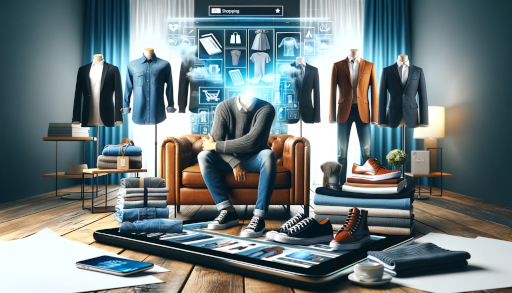

Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.


In [9]:
# Run the cells below first

In [10]:
!pip install torchmetrics

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall, ConfusionMatrix


In [17]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [13]:
# Get the number of classes
classes = train_data.classes
num_classes = len(train_data.classes)

# Define some relevant variables
num_input_channels = 1
num_output_channels = 16
image_size = train_data[0][0].shape[1]

In [14]:
# Start coding here
# Use as many cells as you need
dataloader_train = DataLoader(
  train_data, shuffle=True, batch_size=10
)

dataloader_test = DataLoader(
  test_data, shuffle=True, batch_size=10
)
# Define CNN
class MultiClassImageClassifier(nn.Module):

    # Define the init method
    def __init__(self, num_classes):
        super(MultiClassImageClassifier, self).__init__()

        # Define the convolutional, pooling, and fully connected layers
        self.conv1 = nn.Conv2d(num_input_channels, num_output_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        # Create a fully connected layer
        self.fc = nn.Linear(num_output_channels * (image_size//2)**2, num_classes)

    def forward(self, x):
        # Pass input through the convolutional and pooling layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [15]:
# Define training function
def train_model(optimizer, net, num_epochs):
    num_processed = 0
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        running_loss = 0
        num_processed = 0
        for features, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_processed += len(labels)
        print(f'epoch {epoch}, loss: {running_loss / num_processed}')

    train_loss = running_loss / len(dataloader_train)

# Train for 1 epoch
net = MultiClassImageClassifier(num_classes)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=1,
)

epoch 0, loss: 0.040302539157572516


In [19]:
# Test the model on the test set

# Define the test set DataLoader
dataloader_test = DataLoader(
    test_data,
    batch_size=10,
    shuffle=False,
)
# Define the metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)
precision_metric = Precision(task='multiclass', num_classes=num_classes, average=None)
recall_metric = Recall(task='multiclass', num_classes=num_classes, average=None)
confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=num_classes)

# Run model on test set

net.eval()
predicted = []
for i, (features, labels) in enumerate(dataloader_test):
    output = net.forward(features.reshape(-1, 1, image_size, image_size))
    cat = torch.argmax(output, dim=-1)
    predicted.extend(cat.tolist())
    accuracy_metric(cat, labels)
    precision_metric(cat, labels)
    recall_metric(cat, labels)
    confusion_matrix(cat, labels)

# Compute the metrics
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()
confusion_metric = confusion_matrix.compute()
print('Accuracy:', accuracy)

print('Precision (per class):', precision)

print('Recall (per class):', recall)

print('Confusion MAtrix: ', confusion_metric)

Accuracy: 0.8664000034332275
Precision (per class): [0.8319587707519531, 0.9797570705413818, 0.8116817474365234, 0.9092849493026733, 0.8586251735687256, 0.9825640916824341, 0.5621257424354553, 0.9512448310852051, 0.9650349617004395, 0.9173709154129028]
Recall (per class): [0.8069999814033508, 0.9679999947547913, 0.8059999942779541, 0.8519999980926514, 0.6620000004768372, 0.9580000042915344, 0.7509999871253967, 0.9169999957084656, 0.9660000205039978, 0.9769999980926514]
Confusion MAtrix:  tensor([[807,   0,  13,  20,   3,   2, 143,   0,  12,   0],
        [  0, 968,   2,  15,   3,   0,  11,   0,   1,   0],
        [ 16,   1, 806,   6,  41,   0, 128,   0,   2,   0],
        [ 21,  14,   8, 852,  26,   0,  78,   0,   1,   0],
        [  1,   1, 102,  24, 662,   0, 206,   0,   4,   0],
        [  0,   0,   0,   0,   0, 958,   1,  25,   1,  15],
        [122,   2,  61,  17,  35,   0, 751,   0,  12,   0],
        [  0,   0,   0,   0,   0,   9,   0, 917,   1,  73],
        [  3,   2,   1,   3